In [2]:
#导入所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#输出显示中文
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "C:\Windows\Fonts\simkai.ttf")

import re
import string
import copy
import time
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as DataFrame

#处理文本
from torchtext import data
from torchtext.legacy import data
from torchtext.vocab import Vectors

#数据可视化
import torchvision
import torchvision.transforms as transforms

In [7]:
#使用trochtext库进行数据准备
#定义文件中对文本和标签所要做的操作
"""
sequential=True:表明输入的文本是字符，而不是数值
tokenize="spacy":使用spacy切分词语
use_vocab=True:创建一个词汇表
batch_first=True:batch优先的数据方式
fix_length=40:每条评论固定长度为40
"""

#定义文本切分方法，因为前面已经做过处理，所以直接使用空格切分
mytokenize = lambda x:x.split()
labeltokenize = lambda x : [int(x[0])]

TEXT = data.Field(sequential=True, tokenize=mytokenize,
                    include_lengths=True, use_vocab=True,
                    batch_first=True, fix_length=40)
LABEL = data.Field(sequential=True, use_vocab=False,
                    pad_token=None, unk_token=None,
                    tokenize=labeltokenize)

#对要读取的数据集的列进行处理
text_data_fields = [
    ("label", LABEL),  #对标签的操作
    ("cutword", TEXT)  #对文本的操作
    ]


In [8]:
#读取数据
traindata, valdata, testdata = data.TabularDataset.splits(
    path="datasets", format="csv",
    train="train_set.csv",fields=text_data_fields,
    validation="valid_set.csv",
    test="test_set.csv", skip_header=True)

In [9]:
#查看训练集、验证集、测试集大小
len(traindata),len(valdata),len(testdata)

(68192, 22732, 22730)

In [10]:
#加载预训练的词向量和构建词汇表
#Vectors导入预训练好的词向量文件
vectors = Vectors(name='datasets/sgns.weibo.bigram-char')
# 指定Vector缺失值的初始化方式，没有命中的token的初始化方式
vectors.unk_init = nn.init.xavier_uniform_
#使用训练集构建单词表，导入预训练的中文词向量
TEXT.build_vocab(traindata, vectors=vectors)
LABEL.build_vocab(traindata)

In [11]:
#定义一个迭代器，将类似长度的示例一起批处理
BATCH_SIZE = 128
train_iter = data.BucketIterator(traindata, batch_size=BATCH_SIZE)
val_iter = data.BucketIterator(valdata, batch_size=BATCH_SIZE)
test_iter = data.BucketIterator(testdata, batch_size=BATCH_SIZE)

In [12]:
#获得一个batch的数据，对数据进行内容介绍
for step, batch in enumerate(train_iter):
    textdata, target = batch.cutword[0], batch.label.view(-1)
    if step > 0:
        break

In [13]:
print(textdata.shape)
print(target.shape)

torch.Size([128, 40])
torch.Size([128])


In [14]:
#定义GRU网络模型
class BiGRUNet(nn.Module):
    #模型初始化函数
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes):
        '''
        vocab_size:词典长度
        embedding_dim:词向量维度
        hidden_size:隐藏神经元个数
        num_layers:隐藏层层数
        num_classes:隐藏层输出的维度（分类数量）
        '''
        super(BiGRUNet,self).__init__()
        self.hidden_size = hidden_size #GRU神经元个数
        self.num_layers = num_layers  #GRU的层数
        #对文本进行词向量处理
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #GRU层
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers,
                          bidirectional=True, batch_first=True, dropout=0.5)
        #全连接Dropout层
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
            
        
        )
    #前向传播函数          
    def forward(self,x):
        embeds = self.embedding(x)
        #GRU实例有两个返回结果r_out和h_state
        #r_out：每个时间步的输出值(h_t,c_t)
        #h_state：最后一个时间步Hidden State和Cell State组成的二维Tuple(h_n,c_n)
        #h_n和c_n都初始化为形状为[num_layers*num_directions,batch,hidden_size]的Zero Tensor
        r_out, h_state = self.gru(embeds, None)
        #选取最后一个时间步的输出out
        out = self.fc(r_out[:,-1,:])
        return out

In [15]:
#初始化网络
vocab_size = len(TEXT.vocab) #词表大小
embedding_dim = vectors.dim #词向量维度
hidden_size = 128 
num_layers = 2
num_classes = 2 

In [16]:
#创建模型  
bigru_model = BiGRUNet(vocab_size, embedding_dim, hidden_size, num_layers, num_classes)
bigru_model

BiGRUNet(
  (embedding): Embedding(100450, 300)
  (gru): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [17]:
#将导入的词向量作为embedding.weight的初始值
bigru_model.embedding.weight.data.copy_(TEXT.vocab.vectors)

tensor([[-0.0774, -0.1138, -0.0789,  ...,  0.0934,  0.0380,  0.0385],
        [-0.1236,  0.0375, -0.0504,  ...,  0.0386, -0.0015, -0.0173],
        [ 0.6539,  0.7563,  0.6598,  ...,  0.0087, -0.1006,  0.6101],
        ...,
        [ 0.3087,  0.1839,  0.1465,  ..., -0.3507,  0.1528, -0.3567],
        [-0.1111, -0.0252, -0.1244,  ...,  0.0103,  0.0020,  0.1102],
        [ 0.0941,  0.3078,  0.0232,  ..., -0.4266,  0.2949,  0.2510]])

In [18]:
#定义网络的训练过程函数
def train(model, train_loader, val_loader, criterion,
          optimizer, num_epochs):
    '''
    model:网络模型;
    train_loader:训练集加载;
    val_loader:验证集加载;
    criterion:损失函数;
    optimizer:优化方法
    num_epochs:训练的轮数（迭代次数）
    '''
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    learn_rate = []
    start_time = time.time()
    print('stat_time：',start_time)
    #设置等间隔调整学习率，每隔step_size个epoch，学习率缩小1/10
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5,gamma=0.1)
    for epoch in range(num_epochs):
        learn_rate.append(scheduler.get_last_lr()[0])
        print('-' * 20)
        print('Epoch：{}/{}, LR：{}'.format(epoch, num_epochs-1, learn_rate[-1]))
        #每个epoch有两个阶段，训练阶段和验证阶段
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        model.train() #设置模型为训练模式
        for step, batch in enumerate(train_loader):
            textdata, target = batch.cutword[0],batch.label.view(-1)
            out = model(textdata)
            pre_lab = torch.argmax(out,1) #预测的标签
            loss = criterion(out, target) #计算损失函数值
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(target)
            train_corrects += torch.sum(pre_lab == target.data)
            train_num += len(target)
        #计算一个epoch在训练集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)
        print('{} Train Loss：{:.4f} Train Acc：{:.4f}'.format(
            epoch, train_loss_all[-1], train_acc_all[-1]))
        scheduler.step() #更新学习率
        
        #计算一个epoch的训练后在验证集上的损失和精度
        model.eval() #设置模型为评估模式
        for step, batch in enumerate(val_loader):
            textdata, target = batch.cutword[0], batch.label.view(-1)
            out = model(textdata)
            pre_lab = torch.argmax(out,1) #预测的标签
            loss = criterion(out, target) #计算损失函数
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            val_loss += loss.item() * len(target)
            val_corrects += torch.sum(pre_lab == target.data)
            val_num += len(target)
        
        #计算一个epoch在验证集上的损失和精度
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item() / val_num)
        print('{} Val Loss：{:.4f} Val Acc：{:.4f}'.format(
            epoch, val_loss_all[-1], val_acc_all[-1]))
    
    end_time = time.time()
    print('end_time：',end_time)
    
    train_process = pd.DataFrame(
        data = {"epoch":range(num_epochs),
                "train_loss_all":train_loss_all,
                "train_acc_all":train_acc_all,
                "val_loss_all":val_loss_all,
                "val_acc_all":val_acc_all,
                "learn_rate":learn_rate})
    return model, train_process

In [19]:
#定义优化器
optimizer = optim.Adam(bigru_model.parameters(), lr=0.003) #优化器,lr:学习率为0.003
loss_func = nn.CrossEntropyLoss() #交叉熵作为损失函数
num_epochs = 10 #训练的轮数（迭代次数）

In [15]:
#对模型进行迭代训练
bigru_model, train_process = train(
    bigru_model,train_iter, val_iter, loss_func, optimizer, num_epochs)

stat_time： 1673686675.4578972
--------------------
Epoch：0/9, LR：0.003
0 Train Loss：0.5973 Train Acc：0.6545
0 Val Loss：0.5235 Val Acc：0.7366
--------------------
Epoch：1/9, LR：0.003
1 Train Loss：0.4168 Train Acc：0.8171
1 Val Loss：0.4031 Val Acc：0.8121
--------------------
Epoch：2/9, LR：0.003
2 Train Loss：0.2311 Train Acc：0.9031
2 Val Loss：0.2559 Val Acc：0.8886
--------------------
Epoch：3/9, LR：0.003
3 Train Loss：0.1414 Train Acc：0.9392
3 Val Loss：0.1495 Val Acc：0.9350
--------------------
Epoch：4/9, LR：0.003
4 Train Loss：0.1020 Train Acc：0.9541
4 Val Loss：0.1293 Val Acc：0.9450
--------------------
Epoch：5/9, LR：0.00030000000000000003
5 Train Loss：0.0624 Train Acc：0.9719
5 Val Loss：0.0832 Val Acc：0.9634
--------------------
Epoch：6/9, LR：0.00030000000000000003
6 Train Loss：0.0550 Train Acc：0.9754
6 Val Loss：0.0642 Val Acc：0.9713
--------------------
Epoch：7/9, LR：0.00030000000000000003
7 Train Loss：0.0488 Train Acc：0.9776
7 Val Loss：0.0533 Val Acc：0.9758
--------------------
Epoch：8/9,

In [16]:
#输出结果保存和数据保存
torch.save(bigru_model,"model.pkl")

In [20]:
#导入保存的模型
bigru_model = torch.load("model.pkl")
bigru_model

BiGRUNet(
  (embedding): Embedding(100450, 300)
  (gru): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [17]:
#保存训练过程
train_process.to_csv("bigru_train_process.csv",index=False)

In [18]:
train_process = pd.read_csv("bigru_train_process.csv")
train_process

,epoch,train_loss_all,train_acc_all,val_loss_all,val_acc_all,learn_rate
0,0,0.597311,0.654549,0.523494,0.736583,0.0030
1,1,0.416790,0.817134,0.403114,0.812071,0.0030
2,2,0.231105,0.903112,0.255949,0.888615,0.0030
3,3,0.141432,0.939245,0.149532,0.934982,0.0030
4,4,0.101989,0.954071,0.129290,0.944967,0.0030
5,5,0.062353,0.971888,0.083244,0.963400,0.0003
6,6,0.055035,0.975422,0.064215,0.971274,0.0003
7,7,0.048784,0.977593,0.053329,0.975849,0.0003
8,8,0.043758,0.979514,0.045842,0.979412,0.0003
9,9,0.040878,0.981361,0.045545,0.980732,0.0003


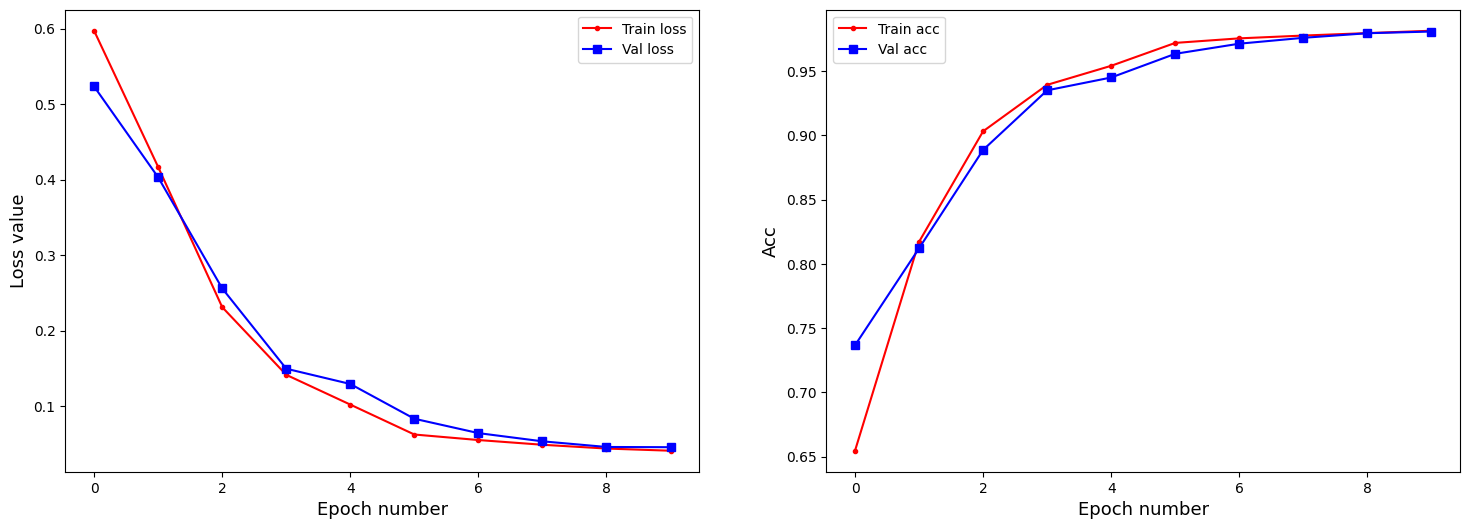

In [19]:
#可视化训练过程
plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(train_process.epoch, train_process.train_loss_all,
         "r.-", label = "Train loss")
plt.plot(train_process.epoch, train_process.val_loss_all,
         "bs-", label = "Val loss")
plt.legend()
plt.xlabel("Epoch number", size = 13)
plt.ylabel("Loss value",size = 13)
plt.subplot(1, 2, 2)
plt.plot(train_process.epoch, train_process.train_acc_all,
         "r.-", label = "Train acc")
plt.plot(train_process.epoch, train_process.val_acc_all,
         "bs-", label = "Val acc")
plt.xlabel("Epoch number", size = 13)
plt.ylabel("Acc",size = 13)
plt.legend()
plt.show()

In [21]:
#对测试集进行预测并计算精度
bigru_model.eval() #设置模型为评估模式
test_y_all = torch.LongTensor()
pre_lab_all = torch.LongTensor()
for step, batch in enumerate(test_iter):
    textdata, target = batch.cutword[0], batch.label.view(-1)
    out = bigru_model(textdata)
    pre_lab = torch.argmax(out, 1)
    test_y_all = torch.cat((test_y_all, target)) #测试集的标签
    pre_lab_all = torch.cat((pre_lab_all,pre_lab)) #测试集的预测标签
    
acc = accuracy_score(test_y_all, pre_lab_all)
print("在测试集上的预测精度为：", acc)

在测试集上的预测精度为： 0.6942366915970084


D:\Anaconda3\envs\pytorch\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 36127 (\N{CJK UNIFIED IDEOGRAPH-8D1F}) missing from current font.
  fig.canvas.draw()
D:\Anaconda3\envs\pytorch\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 21521 (\N{CJK UNIFIED IDEOGRAPH-5411}) missing from current font.
  fig.canvas.draw()
D:\Anaconda3\envs\pytorch\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from current font.
  fig.canvas.draw()


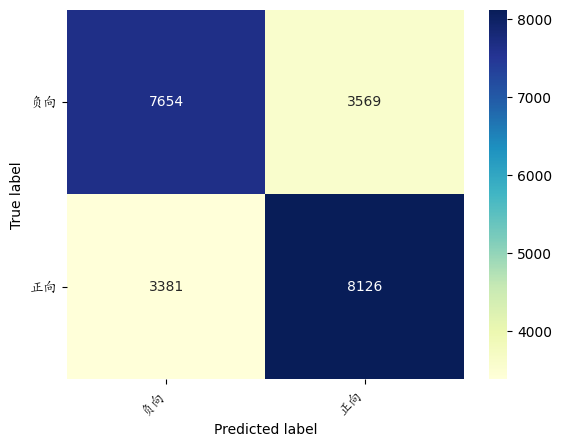

In [21]:
#计算混淆矩阵并可视化
class_label = ["负向", "正向"]
conf_mat = confusion_matrix(test_y_all, pre_lab_all)
df_cm = pd.DataFrame(conf_mat, index=class_label, columns=class_label)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontproperties=fonts)
heatmap.xaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45,
                             ha='right', fontproperties=fonts)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()